# Statistics and Figures for Analysis by Climate Zone

## Initialisation

In [1]:
import json
import numpy as np
import os
import pandas as pd
import seaborn as sns

from scipy import stats

import matplotlib.pyplot as plt

import initialise
import common
from analysis_utils import calc_statistics
from display_utils import display_frames

In [2]:
SCENARIOS = ['within-site', 'out-of-site']
DISPLAY_NAMES = [' '.join([s.capitalize(), 'Models']) for s in SCENARIOS]
samples_file = os.path.join(common.DATASETS_DIR, 'samples_365days.csv')
model_dir1 = os.path.join(common.MODELS_DIR, f'{SCENARIOS[0]}_models')
model_dir2 = os.path.join(common.MODELS_DIR, f'{SCENARIOS[1]}_models')
output_dir = common.FIGURES_DIR

In [3]:
model = common.ANALYSIS_MODEL
ensemble_size = common.ENSEMBLE_SIZE
ensemble_runs = common.ENSEMBLE_RUNS

In [4]:
WITHIN_SITE_RMSE = 20.9
OUT_OF_SITE_RMSE = 25.4
WITHIN_SITE_R2 = 0.70
OUT_OF_SITE_R2 = 0.54
TEXT_SIZE = 7
FONT_SIZE = 8
TITLE_SIZE = 10
MARKER_SIZE = 7
LINE_WIDTH = 1.0
SATURATION = 0.6

## Get the Samples and Predictions

In [5]:
with open(os.path.join(model_dir1, 'model_params.json'), 'r') as f:
    ws_params = json.load(f)
samples2 = pd.read_csv(samples_file, index_col=0)
predict2 = pd.read_csv(os.path.join(model_dir2, f'ensemble{ensemble_size}_{model}.csv'), index_col=0).reindex(samples2.index)

predict1 = pd.read_csv(os.path.join(model_dir1, f'ensemble{ensemble_size}_{model}.csv'), index_col=0)
samples1 = samples2.reindex(predict1.index)

## Functions

### Statistical functions

In [6]:
def rmse(errors):
    return np.sqrt((errors ** 2).mean())

In [7]:
def gen_stats(y, yhat):
    data = pd.DataFrame({'y': y['LFMC value'], 'yhat': yhat, 'Climate Zone': y['Czone3']})
    data['Pred_error'] = data.yhat - data.y
    data['tss'] = (data.y - data.y.mean()) ** 2
    data['rss'] = (data.yhat - data.y) ** 2
    stats_ = data.groupby(['Climate Zone']).agg({'Pred_error': ['mean', rmse], 'tss': ['sum'], 'rss': ['sum']}).reset_index()
    stats_.columns = ['Climate Zone', 'mean', 'rmse', 'tss', 'rss']
    stats_['r2'] = 1 - stats_.rss / stats_.tss
    return stats_  

In [8]:
def gen_means(y, yhat):
    stats_ = pd.concat([gen_stats(y, p[1]) for p in yhat.items()])
    return stats_.groupby('Climate Zone').agg(
        bias=pd.NamedAgg(column='mean', aggfunc='mean'),
        bias_std=pd.NamedAgg(column='mean', aggfunc='std'),
        rmse=pd.NamedAgg(column='rmse', aggfunc='mean'),
        rmse_std=pd.NamedAgg(column='rmse', aggfunc='std'),
        r2=pd.NamedAgg(column='r2', aggfunc='mean'),
        r2_std=pd.NamedAgg(column='r2', aggfunc='std'),
    )

### Plotting functions

In [9]:
def samples_plot(data, plot_order, czones, ax, label):
    data = data.sort_values(['count'])
    sns.barplot(y=data.Czone3, x=data['mean'], xerr=data['std'], palette=czones,
                saturation=SATURATION, error_kw=dict(lw=LINE_WIDTH), ax=ax, zorder=2)
    ax.set_ylabel('Climate Zone')
    ax.set_xlabel(f'({label}) Measured LFMC', fontsize=FONT_SIZE)

    ypos = ax.get_yticks()
    for n, c in data.reset_index()['count'].items():
        ax.text(1, ypos[n], c, va='center', size=TEXT_SIZE, zorder=3)
    ax.text(1, -ypos[1] - 0.1, 'Samples', va='top')

    ax.set_xlim((0, 200))
    ax.set_xticks(range(0, 250, 50))
    ax.set_xticklabels([f'{i}%' for i in range(0, 250, 50)], fontsize=TEXT_SIZE)
    return ax

In [10]:
def results_plot(samples, predict, data, plot_order, czones, xlim, xline, ylim, ax, label):
    ax.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, zorder=1)

    bp_data = (predict.T - samples['LFMC value']).T
    bp_data['Czone3'] = samples['Czone3']
    bp_data = bp_data.set_index('Czone3').unstack().reset_index()
    bp_data.columns = ['Ensemble', 'Czone3', 'Error']

    whiskers = bp_data.groupby(['Czone3'])['Error'].describe()[['25%', '75%']]
    whiskers['iqr'] = whiskers.diff(axis=1)['75%']
    whiskers['lower'] = whiskers['25%'] - 1.5 * whiskers['iqr']
    whiskers['upper'] = whiskers['75%'] + 1.5 * whiskers['iqr']
    
    sns.boxplot(y='Czone3', x='Error', data=bp_data, order=plot_order, palette=czones,
                saturation=SATURATION, width=0.7, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2}, whiskerprops={'zorder': 2})
    for num, ytick in enumerate(ax2.get_yticks()):
        y_off = ytick
        rmse = data.set_index('Climate Zone').rmse.loc[plot_order[num]]
        bias_ = data.set_index('Climate Zone').bias.loc[plot_order[num]]
        pt, = ax.plot(rmse, y_off, 'dk', mfc=czones[num], markersize=MARKER_SIZE, zorder=3)
        ax.text(rmse+3, y_off, round(rmse,2), va='bottom', ha='left', size=TEXT_SIZE)
        t = ax.text(xlim[0]+1, y_off, round(bias_,2), va='bottom', ha='left', size=TEXT_SIZE)
    ax.set_ylabel(None)
    ax.set_xlabel(f'({label}) Estimation Error Distribution, RMSE and Bias', fontsize=FONT_SIZE)
    ax.set_xlim(xlim)
    ax.set_xticks(range(xlim[0], xlim[1]+1, 40))
    ax.set_xticklabels([f'{i}%' for i in range(xlim[0], xlim[1]+1, 40)], fontsize=TEXT_SIZE)
    ypos = ax.get_yticks()
    ax.text(xlim[0], -ypos[1] - 0.1, 'Bias (%)', va='top')
    return ax

In [11]:
def r2_plot(samples, predict, data, plot_order, czones, xlim, xline, ylim, ax, label):
    bp_data = predict.copy()
    bp_data['Czone3'] = samples['Czone3']
    bp_data = bp_data.set_index('Czone3').unstack().reset_index()
    bp_data.columns = ['Ensemble', 'Czone3', 'Estimation']

    sns.boxplot(y='Czone3', x='Estimation', data=bp_data, order=plot_order, palette=czones,
                saturation=SATURATION, width=0.7, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2}, whiskerprops={'zorder': 2})

    whiskers = bp_data.groupby(['Czone3'])['Estimation'].describe()[['25%', '75%']]
    whiskers['iqr'] = whiskers.diff(axis=1)['75%']
    whiskers['lower'] = whiskers['25%'] - 1.5 * whiskers['iqr']
    whiskers['upper'] = whiskers['75%'] + 1.5 * whiskers['iqr']

    xlim1 = [-0.5, 1.05]
    ax1=ax.twiny()
    ax1.set_xlim(xlim1)
    ax1.set_xlabel("$R^2$", color="blue", fontsize=TEXT_SIZE)
    plt.setp(ax1.get_xticklabels(), color="blue")
    ax1.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, zorder=1)

    for num, ytick in enumerate(ax2.get_yticks()):
        y_idx = plot_order[num]
        r2 = data.set_index('Climate Zone').r2.loc[y_idx]
        pt, = ax1.plot(r2, ytick, '*k', mfc=czones[num], markersize=MARKER_SIZE+2, zorder=3)
        x_off = -0.05 if r2 > 0.85 else 0.05
        ha = 'right' if r2 > 0.85 else 'left'
        r2_scaled = ((r2 - xlim1[0]) / (xlim1[1] - xlim1[0])) * (xlim[1] - xlim[0]) + xlim[0]
        if whiskers.loc[y_idx, 'lower'] <= r2_scaled <= whiskers.loc[y_idx, 'upper']:
            va = 'bottom'
        else:
            va = 'center'
        ax1.text(r2 + x_off, ytick, round(r2,2), va=va, ha=ha, color='b', size=TEXT_SIZE)
    ax.set_ylabel(None)
    ax.set_xlabel(f'({label}) LFMC Estimation Distribution and $R^2$', fontsize=FONT_SIZE)
    ax.set_xlim(xlim)
    ax.set_xticks(range(xlim[0], xlim[1]+1, 40))
    ax.set_xticklabels([f'{i}%' for i in range(xlim[0], xlim[1]+1, 40)], fontsize=TEXT_SIZE)
    return ax

## Calculate Metrics by Climate Zone

In [12]:
data_summ = [samples1.groupby(['Czone3'])['LFMC value'].agg(['mean', 'std', 'count']).reset_index(),
             samples2.groupby(['Czone3'])['LFMC value'].agg(['mean', 'std', 'count']).reset_index()]
data1 = gen_means(samples1, predict1).reset_index()
data2 = gen_means(samples2, predict2).reset_index()

display_frames(
    [data_summ[1], data1.convert_dtypes(), data2.convert_dtypes()],
    ['Measured LFMC'] + DISPLAY_NAMES,
    precision=2
)

,Czone3,mean,std,count
0,BSh,123.25,52.03,922
1,BSk,112.02,38.49,24258
2,BWh,59.08,4.91,39
3,BWk,114.21,47.52,2300
4,Cfa,120.18,29.20,4595
5,Cfb,119.28,39.96,289
6,Csa,86.37,31.01,11441
7,Csb,104.22,38.53,4576
8,Dfa,110.59,39.63,380
9,Dfb,112.17,28.14,8334


## Generate the Figure

### Figure Colours
Colours are the ones used by Beck et al. in their paper "Present and future Köppen-Geiger climate classification maps at 1-km resolution" (DOI: 10.1038/sdata.2018.214)

In [13]:
data = data_summ[1].sort_values(['count'])
plot_order = list(data['Czone3'])
czone_colours = [
  '#0000FF', '#0078FF', '#46AAFA', '#FF0000', '#FF9696', '#F5A500',
  '#FFDC64', '#FFFF00', '#C8C800', '#969600', '#96FF96', '#64C864',
  '#329632', '#C8FF50', '#64FF50', '#32C800', '#FF00FF', '#C800C8',
  '#963296', '#966496', '#AAAFFF', '#5A78DC', '#4B50B4', '#320087',
  '#00FFFF', '#37C8FF', '#007D7D', '#00465F', '#B2B2B2', '#666666',
]
czone_names = [
  'Af',  'Am',  'Aw',  'BWh', 'BWk', 'BSh',
  'BSk', 'Csa', 'Csb', 'Csc', 'Cwa', 'Cwb',
  'Cwc', 'Cfa', 'Cfb', 'Cfc', 'Dsa', 'Dsb',
  'Dsc', 'Dsd', 'Dwa', 'Dwb', 'Dwc', 'Dwd',
  'Dfa', 'Dfb', 'Dfc', 'Dfd', 'ET',  'EF']
czones = pd.DataFrame({'names': czone_names, 'colours': czone_colours}).set_index(['names']).loc[plot_order, 'colours']

Plot the Figure

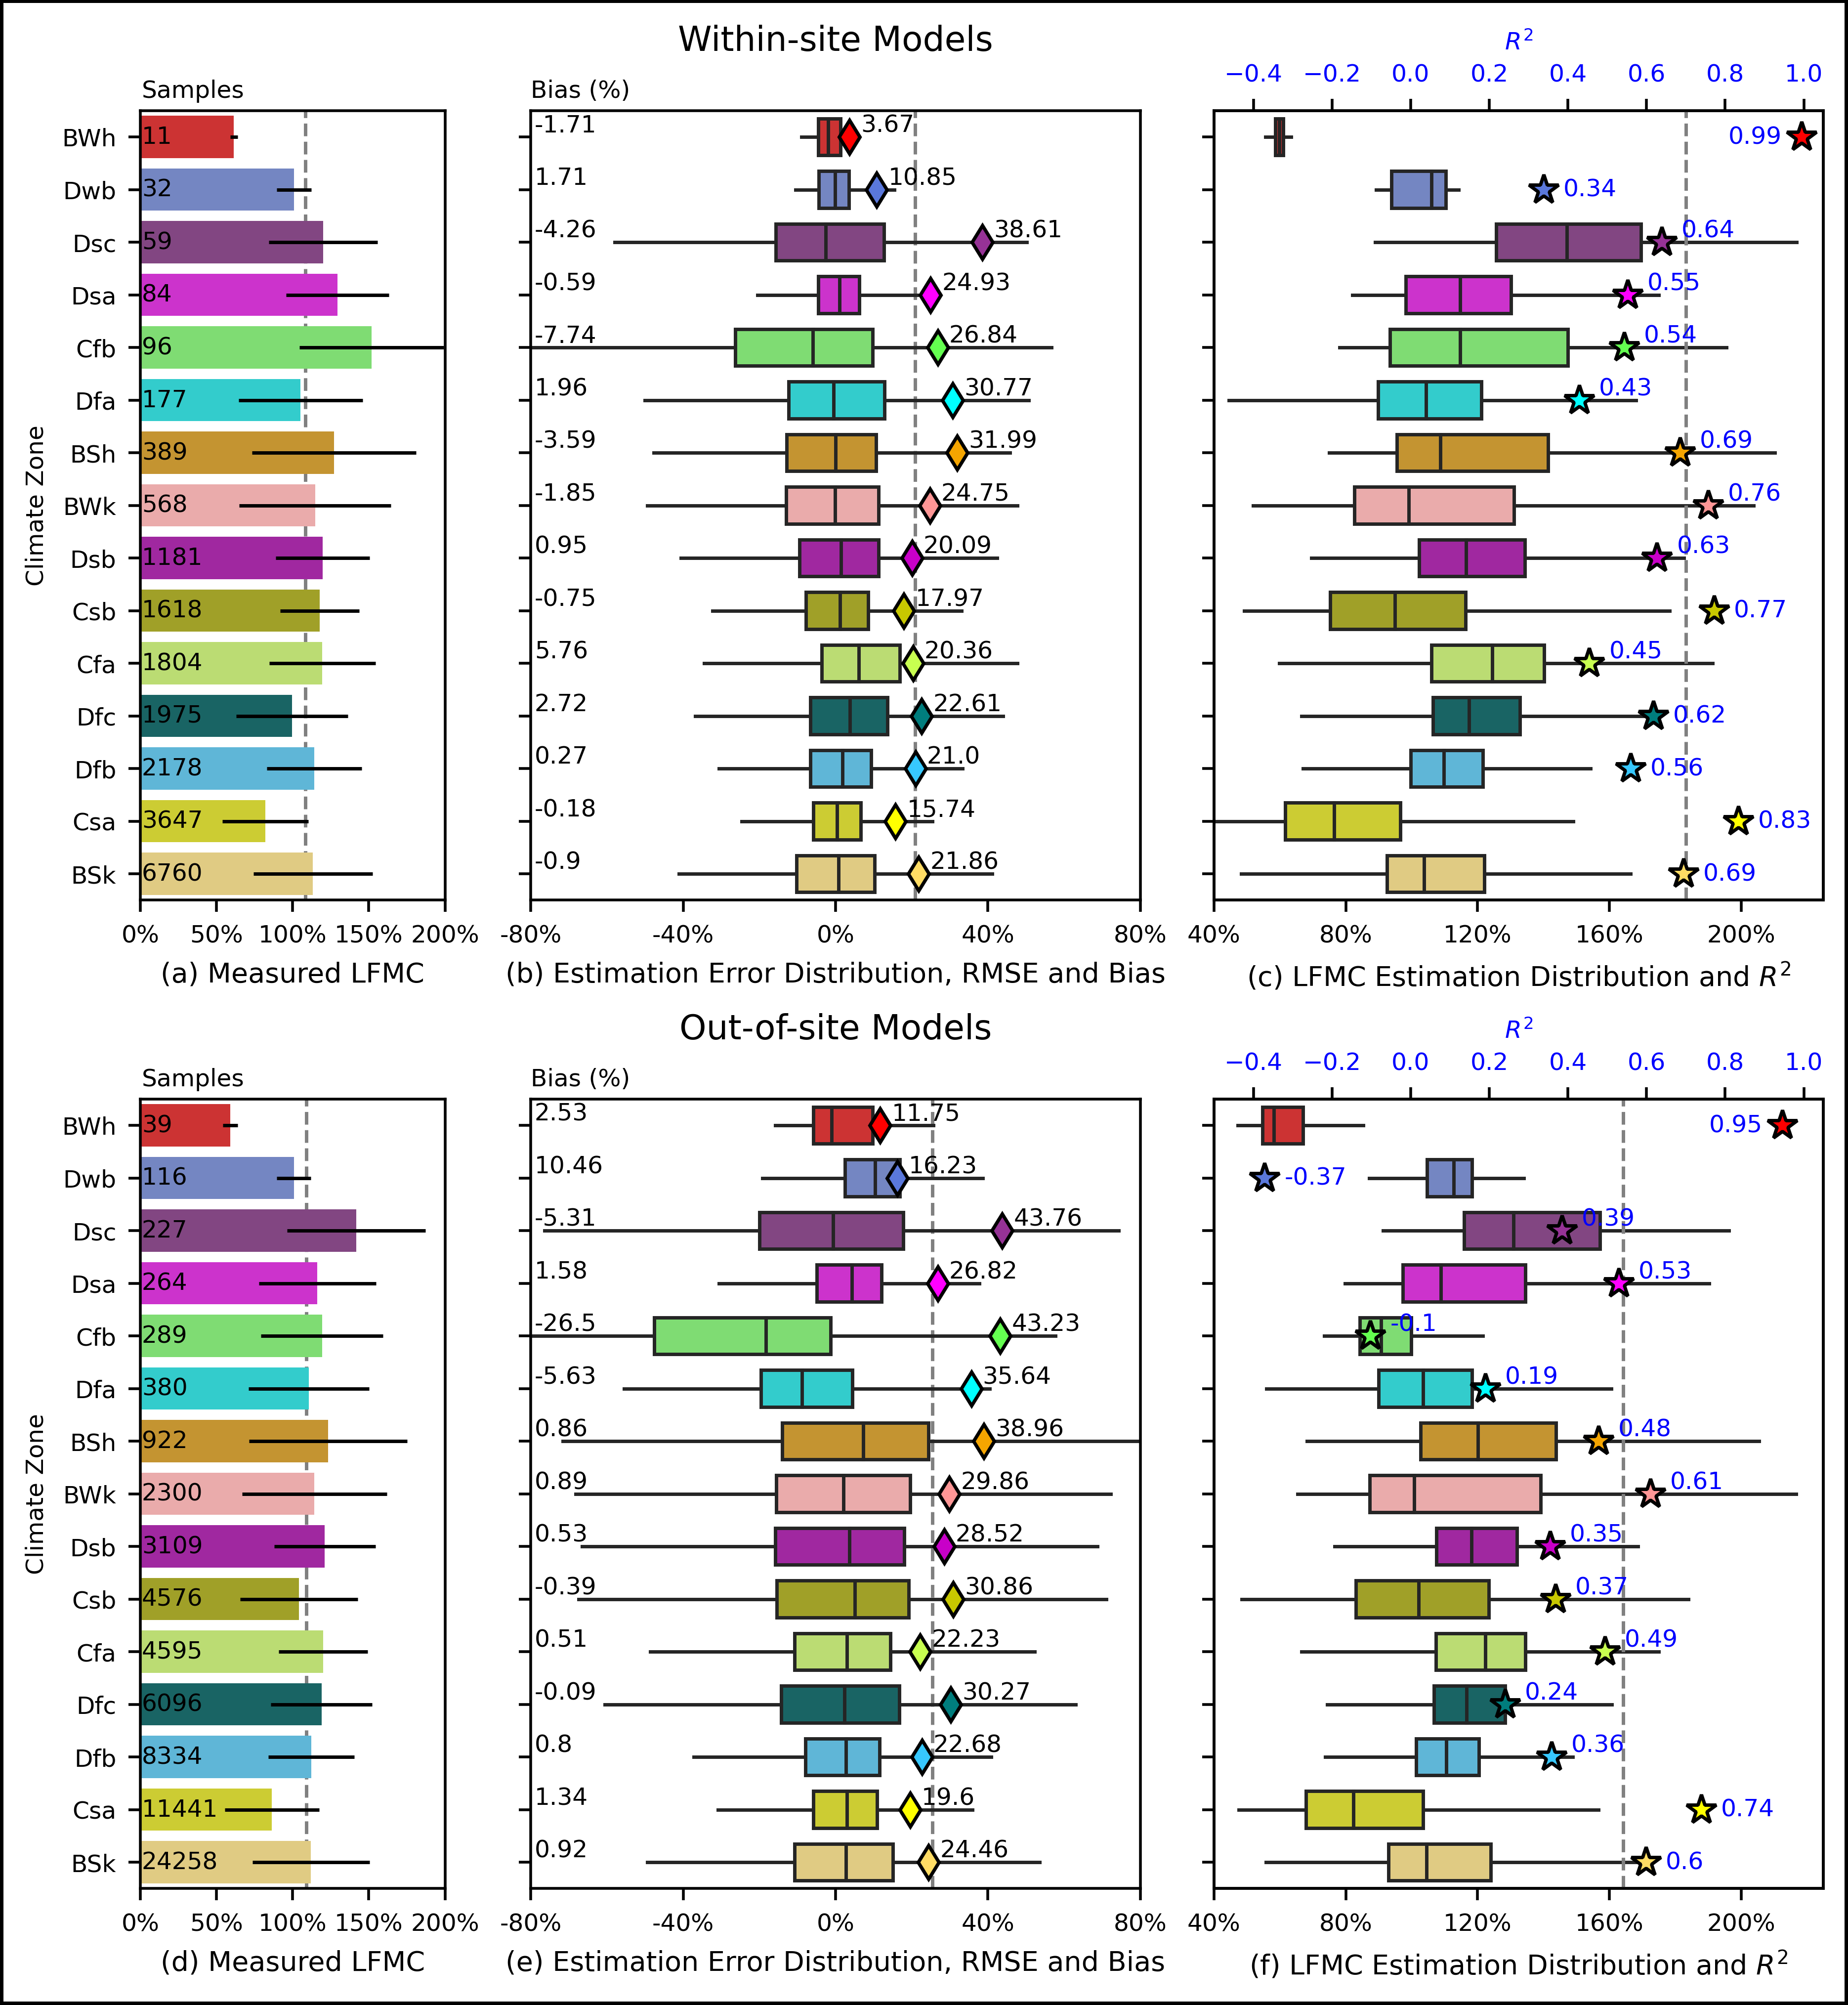

In [14]:
xlim_rmse = (-80, 80)
xlim_r2 = (-0.5, 1.05)
xlim_lfmc = (40, 225)

plt.rcParams.update({'font.size': TEXT_SIZE})
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    2, 3, figsize=(7.364, 8), gridspec_kw={'width_ratios': [1, 2, 2]},
    sharey=True, sharex=False,
    constrained_layout=True, dpi=500, linewidth=2, edgecolor="black")

ax1 = samples_plot(data_summ[0], plot_order, czones, ax=ax1, label='a')
ylim = ax1.get_ylim()
xline = samples1['LFMC value'].mean()
ax1.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, zorder=1)
ax2 = results_plot(samples1, predict1, data1, plot_order, czones, xlim=xlim_rmse,
                   xline=WITHIN_SITE_RMSE, ylim=ylim, ax=ax2, label='b')
ax2.set_title(f'{DISPLAY_NAMES[0]}', y=1.05, fontsize=TITLE_SIZE)
ax3 = r2_plot(samples1, predict1, data1, plot_order, czones, xlim_lfmc,
              xline=WITHIN_SITE_R2, ylim=ylim, ax=ax3, label='c')

ax4 = samples_plot(data_summ[1], plot_order, czones, ax=ax4, label='d')
ylim = ax4.get_ylim()
xline = samples2['LFMC value'].mean()
ax4.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, zorder=1)
ax5 = results_plot(samples2, predict2, data2, plot_order, czones, xlim=xlim_rmse,
                   xline=OUT_OF_SITE_RMSE, ylim=ylim, ax=ax5, label='e')
ax5.set_title(f'{DISPLAY_NAMES[1]}', y=1.05, fontsize=TITLE_SIZE)
ax6 = r2_plot(samples2, predict2, data2, plot_order, czones, xlim_lfmc,
              xline=OUT_OF_SITE_R2, ylim=ylim, ax=ax6, label='f')

fig.savefig(os.path.join(output_dir, 'Climate zone results.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.1, dpi=500)